<h1> Libraries </h1>

In [1]:
# basic libraries
import os
import time
import math

import numpy as np
import pandas as pd
import datetime

from datetime import datetime as ddt
from datetime import date
import matplotlib.pylab as plt

In [2]:
# pyspark related
from pyspark import SparkContext, SparkConf
sc = SparkContext('local[*]', 'PySpark')

In [3]:
sc.master

u'local[*]'

In [4]:
# spark sql related
from pyspark.sql import DataFrameWriter, SQLContext, Row
from pyspark.sql.types import *
sqlContext = SQLContext(sc)
sql = sqlContext.sql

In [5]:
# plot figure related
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as md
from pylab import *
%matplotlib inline

In [6]:
add = lambda x, y: x+y

<h1> Get Data </h1>

In [7]:
# http://archive.ics.uci.edu/ml/datasets/Zoo
txtRDD = sc.textFile('zoo_data.csv')

In [8]:
# name, hair, feathers, eggs, milk, airborne, aquatic, predator, toothed, backbone, breathes, venomous, fins
# legs, tail, domestic, catsize, type
txtRDD.first()

u'aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1'

<h1> Breif Survey </h1>

In [9]:
# count number of data
txtnum = txtRDD.count()
print "total {} data".format(txtnum)

total 101 data


<h1> Clean Data </h1>

In [10]:
[int(x) if i != 0 else x for i, x in enumerate(txtRDD.first().split(','))]

[u'aardvark', 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 4, 0, 0, 1, 1]

In [11]:
# Usage: clean data directly after read data
# Output: return a Row
def cleanDataToRow(a):
    al = [int(x) if i != 0 else x for i, x in enumerate(a.split(','))]
    return Row(
        name = al[0], hair = al[1], feathers = al[2], eggs = al[3], milk = al[4], airborne = al[5],
        aquatic = al[6], predator = al[7], toothed = al[8], backbone = al[9], breathes = al[10],
        venomous = al[11], fins = al[12], legs = al[13], tail = al[14], domestic = al[15], catsize = al[16],
        category = al[17]
    )

In [12]:
# Usage: get Boolean data directly after read data
# Output: return a numpy array
def getBooleanData(a):
    return np.array([int(x) for i, x in enumerate(a.split(',')) if i not in [0, 13, 17]])

<h1> Calculate Each Percentage </h1>

In [13]:
totalnum = txtRDD.map(getBooleanData).aggregate(np.zeros(15, np.int), add, add)

In [14]:
totalnum

array([43, 20, 59, 41, 24, 36, 56, 61, 83, 80,  8, 17, 75, 13, 44])

In [15]:
y_percentage = totalnum / float(txtnum)
y_percentage

array([ 0.42574257,  0.1980198 ,  0.58415842,  0.40594059,  0.23762376,
        0.35643564,  0.55445545,  0.6039604 ,  0.82178218,  0.79207921,
        0.07920792,  0.16831683,  0.74257426,  0.12871287,  0.43564356])

In [16]:
n_percentage = 1 - y_percentage
n_percentage

array([ 0.57425743,  0.8019802 ,  0.41584158,  0.59405941,  0.76237624,
        0.64356436,  0.44554455,  0.3960396 ,  0.17821782,  0.20792079,
        0.92079208,  0.83168317,  0.25742574,  0.87128713,  0.56435644])

<h1> Initiallize Weight </h1>

In [17]:
y_weight = 1 / y_percentage
y_weight

array([  2.34883721,   5.05      ,   1.71186441,   2.46341463,
         4.20833333,   2.80555556,   1.80357143,   1.6557377 ,
         1.21686747,   1.2625    ,  12.625     ,   5.94117647,
         1.34666667,   7.76923077,   2.29545455])

In [18]:
n_weight = 1 / n_percentage
n_weight

array([ 1.74137931,  1.24691358,  2.4047619 ,  1.68333333,  1.31168831,
        1.55384615,  2.24444444,  2.525     ,  5.61111111,  4.80952381,
        1.08602151,  1.20238095,  3.88461538,  1.14772727,  1.77192982])

<h1> Calculate Each Initial Score </h1>

In [19]:
# y_score, n_score
scoreRDD = txtRDD.map(getBooleanData).map(lambda a: (np.dot(y_weight, a), np.dot(n_weight, np.ones(15, np.int) - a)))

In [20]:
scoreRDD.first()

(13.046382992272191, 13.837955065643236)

<h1> Find Closest Relation </h1>

In [21]:
def calculate_relation_score(a_t, t):
    a_conj = np.ones(15, np.int) - a_t
    y_score = np.dot(y_weight, (t - a_conj) == 1)
    n_score = np.dot(n_weight, (t - a_conj) == -1)
    return y_score + n_score

In [22]:
def relation_score_list(td):
    return txtRDD.map(lambda a: ((a.split(',')[0], a.split(',')[-1]), getBooleanData(a))) \
                 .map(lambda (x, y): (calculate_relation_score(y, td), x)) \
                 .sortByKey(False).map(lambda (x, y): (y, x)).collect()

<h2> Type Three Test by Seasnake </h2>

In [23]:
seasnake_target = txtRDD.filter(lambda x: 'seasnake' in x).first()
seasnake_targetdata = np.array([int(x) for i, x in enumerate(seasnake_target.split(',')) if i not in [0, 13, 17]])
seasnake_targetdata

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0])

In [24]:
seasnake_rsl = relation_score_list(seasnake_targetdata)

In [25]:
# pitviper(5), seasnake(1), slowworm(32), tortoise(76), tuatara(33)
for i, x in enumerate(seasnake_rsl):
    print "{}. {}: {}".format(i+1, x[0], x[1])

1. (u'seasnake', u'3'): 38.7730371252
2. (u'stingray', u'4'): 33.3939644435
3. (u'seawasp', u'7'): 32.1490033789
4. (u'frog', u'5'): 30.2120847442
5. (u'pitviper', u'3'): 28.7531958553
6. (u'scorpion', u'7'): 28.2853525853
7. (u'piranha', u'4'): 22.540894268
8. (u'bass', u'4'): 22.540894268
9. (u'catfish', u'4'): 22.540894268
10. (u'chub', u'4'): 22.540894268
11. (u'herring', u'4'): 22.540894268
12. (u'pike', u'4'): 20.7689644435
13. (u'tuna', u'4'): 20.7689644435
14. (u'dogfish', u'4'): 20.7689644435
15. (u'haddock', u'4'): 20.7373228394
16. (u'seahorse', u'4'): 20.7373228394
17. (u'sole', u'4'): 20.7373228394
18. (u'wasp', u'6'): 19.6772849632
19. (u'carp', u'4'): 19.5895955667
20. (u'crab', u'7'): 19.5240033789
21. (u'crayfish', u'7'): 19.5240033789
22. (u'lobster', u'7'): 19.5240033789
23. (u'starfish', u'7'): 19.5240033789
24. (u'newt', u'5'): 18.9337514109
25. (u'honeybee', u'6'): 18.5295576905
26. (u'octopus', u'7'): 17.7520735544
27. (u'frog', u'5'): 17.5870847442
28. (u'clam',

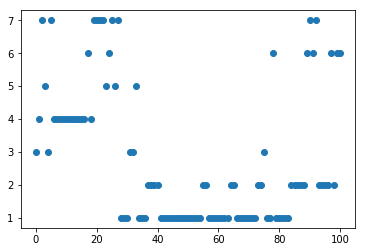

In [26]:
relation_category = [(i, x[0][1]) for i, x in enumerate(seasnake_rsl)]

plt.plot([y for (x,y) in relation_category], 'o')
plt.show()

<h2> Type Four Test by Piranha </h2>

In [27]:
piranha_target = txtRDD.filter(lambda x: 'piranha' in x).first()
piranha_targetdata = np.array([int(x) for i, x in enumerate(piranha_target.split(',')) if i not in [0, 13, 17]])
piranha_targetdata

array([0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0])

In [28]:
piranha_rsl = relation_score_list(piranha_targetdata)

In [29]:
for i, x in enumerate(piranha_rsl):
    print "{}. {}: {}".format(i+1, x[0], x[1])

1. (u'bass', u'4'): 31.2799566508
2. (u'catfish', u'4'): 31.2799566508
3. (u'chub', u'4'): 31.2799566508
4. (u'herring', u'4'): 31.2799566508
5. (u'piranha', u'4'): 31.2799566508
6. (u'dogfish', u'4'): 29.5080268262
7. (u'pike', u'4'): 29.5080268262
8. (u'tuna', u'4'): 29.5080268262
9. (u'seahorse', u'4'): 29.4763852222
10. (u'sole', u'4'): 29.4763852222
11. (u'haddock', u'4'): 29.4763852222
12. (u'stingray', u'4'): 28.4220053208
13. (u'carp', u'4'): 28.3286579495
14. (u'seasnake', u'3'): 22.540894268
15. (u'dolphin', u'1'): 21.3033052766
16. (u'porpoise', u'1'): 21.3033052766
17. (u'crab', u'7'): 21.1195083387
18. (u'crayfish', u'7'): 21.1195083387
19. (u'lobster', u'7'): 21.1195083387
20. (u'starfish', u'7'): 21.1195083387
21. (u'newt', u'5'): 20.5292563706
22. (u'seawasp', u'7'): 20.0334868333
23. (u'sealion', u'1'): 19.5619259662
24. (u'octopus', u'7'): 19.3475785141
25. (u'frog', u'5'): 19.182589704
26. (u'clam', u'7'): 18.3139527832
27. (u'seal', u'1'): 18.2152592996
28. (u'frog'

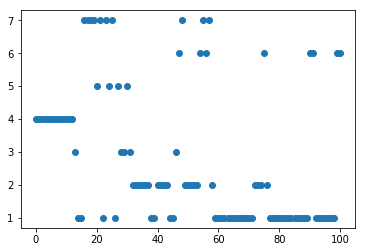

In [30]:
relation_category = [(i, x[0][1]) for i, x in enumerate(piranha_rsl)]

plt.plot([y for (x,y) in relation_category], 'o')
plt.show()

<h2> Type One Test by Lion </h2>

In [31]:
lion_target = txtRDD.filter(lambda x: 'lion' in x).first()
lion_targetdata = np.array([int(x) for i, x in enumerate(lion_target.split(',')) if i not in [0, 13, 17]])
lion_targetdata

array([1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1])

In [32]:
lion_rsl = relation_score_list(lion_targetdata)

In [33]:
for i, x in enumerate(lion_rsl):
    print "{}. {}: {}".format(i+1, x[0], x[1])

1. (u'boar', u'1'): 24.34638934
2. (u'cheetah', u'1'): 24.34638934
3. (u'leopard', u'1'): 24.34638934
4. (u'lion', u'1'): 24.34638934
5. (u'lynx', u'1'): 24.34638934
6. (u'mongoose', u'1'): 24.34638934
7. (u'polecat', u'1'): 24.34638934
8. (u'puma', u'1'): 24.34638934
9. (u'raccoon', u'1'): 24.34638934
10. (u'wolf', u'1'): 24.34638934
11. (u'pussycat', u'1'): 23.1986620672
12. (u'aardvark', u'1'): 22.9997226733
13. (u'bear', u'1'): 22.9997226733
14. (u'mink', u'1'): 22.7925431861
15. (u'antelope', u'1'): 22.5428179114
16. (u'buffalo', u'1'): 22.5428179114
17. (u'deer', u'1'): 22.5428179114
18. (u'elephant', u'1'): 22.5428179114
19. (u'giraffe', u'1'): 22.5428179114
20. (u'oryx', u'1'): 22.5428179114
21. (u'wallaby', u'1'): 22.5428179114
22. (u'mole', u'1'): 22.0509347945
23. (u'opossum', u'1'): 22.0509347945
24. (u'girl', u'1'): 21.8519954006
25. (u'sealion', u'1'): 21.5901622337
26. (u'calf', u'1'): 21.3950906387
27. (u'goat', u'1'): 21.3950906387
28. (u'pony', u'1'): 21.3950906387
29

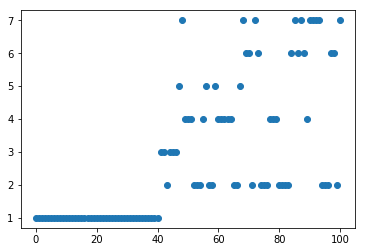

In [34]:
relation_category = [(i, x[0][1]) for i, x in enumerate(lion_rsl)]

plt.plot([y for (x,y) in relation_category], 'o')
plt.show()